In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift, estimate_bandwidth

In [3]:
dataset = make_blobs(n_samples=10000, centers=3, random_state=256)
total_samples = dataset[0].shape[0]
r_train, r_cal, r_test = 0.6, 0.2, 0.2
assert r_train + r_cal + r_test == 1
Z_train = dataset[0][: int(total_samples * r_train)]
Z_cal = dataset[0][
    int(total_samples * r_train) : int(total_samples * r_train)
    + int(total_samples * r_cal)
]
Z_test = dataset[0][int(total_samples * r_train) + int(total_samples * r_cal) :]

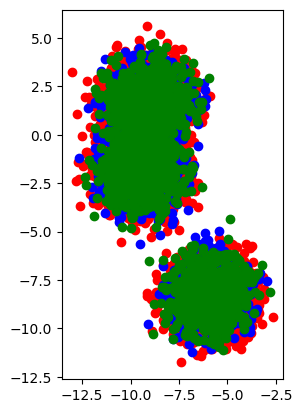

In [4]:
plt.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker="o", label="train")
plt.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker="o", label="cal")
plt.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker="o", label="test")
plt.gca().set_aspect("equal")

In [5]:
from conformal_region_designer.density_estimation import KDE
from conformal_region_designer.clustering import MeanShiftClustering
from conformal_region_designer.shapes import HyperRectangle, ConvexHullTemplate
from conformal_region_designer.conformity_optimizer import ConformalRegion

In [6]:
DELTA = 0.95
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, ConvexHullTemplate, DELTA)

In [7]:
pcr.fit(Z_train)

Generating density points
Fitting Clusters
Fitting Shapes


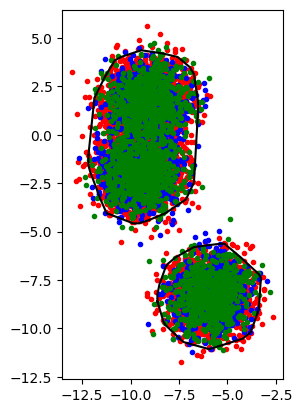

In [8]:
fig, ax = plt.subplots()
ax.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker=".", label="train")
ax.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)

In [9]:
pcr.conformalize(Z_cal)

Target score: -0.20371484252637315


In [10]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
scores = pcr.calculate_scores(Z_cal)
coverage = np.sum(scores < 0) / len(scores)
print("Calibration Coverage: ", coverage)

Test Coverage:  0.9905
Calibration Coverage:  0.9905


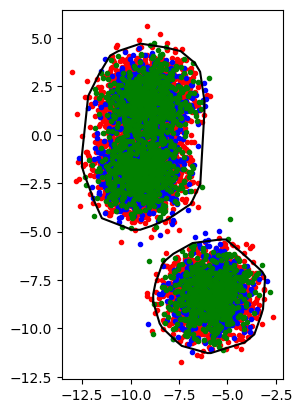

In [15]:
fig, ax = plt.subplots()
ax.scatter(Z_train[:, 0], Z_train[:, 1], color="red", marker=".", label="train")
ax.scatter(Z_cal[:, 0], Z_cal[:, 1], color="blue", marker=".", label="cal")
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test")
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)

In [12]:
from conformal_region_designer.utils import conformalized_quantile
target_quantile = conformalized_quantile(len(Z_train), DELTA)
print(target_quantile)

0.9501583333333333
